In [44]:
import numpy as np
import pandas as pd

import tensorflow as tf

import tensorflow_hub as hub

import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
df = pd.read_csv('D:/BallAITH/train.csv')

In [27]:
texts = []
for i in range(len(df['Filename'])):
    fn = df['Filename'][i]
    folder = fn.split("-")[0]
    f = open('D:/BallAITH/train-data/train-data/'+folder+'/'+fn, "rb")
    texts.append(f.read())
df['text'] = texts

In [28]:
Outcome = df.copy().drop(['Blinding of intervention','Classes'],axis=1)

In [29]:
Outcome

,Filename,Blinding of Outcome assessment,text
0,00060-02.txt,P,b'A Multicomponent Intervention To Prevent Maj...
1,00060-03.txt,N,b'Original article\r\nSelf-management versus c...
2,00060-04.txt,N,b'Original Research\r\nHome Management of Oral...
3,00060-05.txt,P,b'For personal use only. Not to be reproduced ...
4,00060-06.txt,P,b'\xc2\xa9 2016 Pozzi et al. This work is publ...
...,...,...,...
623,00458-20.txt,N,"b""\xef\xbb\xbfEffect of daily versus twice wee..."
624,00458-21.txt,P,b'\xef\xbb\xbfEur J Nutr 39 : 263\xe2\x80\x932...
625,00458-22.txt,N,"b""\xef\xbb\xbfARTICLE\r\n \r\n\r\n \r\nWeekly ..."
626,00458-24.txt,N,b'\xef\xbb\xbfSymposium: Improving Adolescent ...


In [30]:
train_labels,train_examples = Outcome['Blinding of Outcome assessment'],Outcome['text']
train_labels = train_labels.replace(['N','P','Q'],[0,1,2])

In [31]:
print("Training entries: {}".format(len(train_examples)))

Training entries: 628


In [32]:
train_examples[:10]

0    b'A Multicomponent Intervention To Prevent Maj...
1    b'Original article\r\nSelf-management versus c...
2    b'Original Research\r\nHome Management of Oral...
3    b'For personal use only. Not to be reproduced ...
4    b'\xc2\xa9 2016 Pozzi et al. This work is publ...
5    b'ORIGINAL ARTICLE\r\nA randomised controlled ...
6    b'Primary care\r\nSelf management of oral anti...
7    b'Patient self-testing is a reliable and accep...
8    b'e292 Canadian Family Physician \xe2\x80\xa2 ...
9    b'Abstract\r\nThe antithrombotic effect of ora...
Name: text, dtype: object

In [33]:
train_labels[:10]

0    1
1    0
2    0
3    1
4    1
5    0
6    1
7    0
8    1
9    0
Name: Blinding of Outcome assessment, dtype: int64

In [75]:
model = ("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")

hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(5))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_20 (Dense)             (None, 500)               10500     
_________________________________________________________________
dense_21 (Dense)             (None, 100)               50100     
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 505       
Total params: 461,125
Trainable params: 461,125
Non-trainable params: 0
_________________________________________________________________


In [76]:

model.compile(
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.optimizers.Adam(), 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [77]:
x_val = train_examples[:100]
partial_x_train = train_examples[100:]

y_val = train_labels[:100]
partial_y_train = train_labels[100:]

In [78]:
history = model.fit(x=partial_x_train, y=partial_y_train,
          validation_data=(x_val, y_val),
          epochs = 35)

Epoch 1/35
17/17 [==============================] - 1s 47ms/step - loss: 1.5062 - accuracy: 0.3939 - val_loss: 1.1545 - val_accuracy: 0.3000
Epoch 2/35
17/17 [==============================] - 1s 43ms/step - loss: 1.0478 - accuracy: 0.5114 - val_loss: 1.1876 - val_accuracy: 0.3400
Epoch 3/35
17/17 [==============================] - 1s 42ms/step - loss: 1.0572 - accuracy: 0.4848 - val_loss: 1.1731 - val_accuracy: 0.5700
Epoch 4/35
17/17 [==============================] - 1s 43ms/step - loss: 0.9412 - accuracy: 0.5777 - val_loss: 1.0446 - val_accuracy: 0.5700
Epoch 5/35
17/17 [==============================] - 1s 44ms/step - loss: 0.8626 - accuracy: 0.5890 - val_loss: 1.2242 - val_accuracy: 0.3200
Epoch 6/35
17/17 [==============================] - 1s 45ms/step - loss: 0.8734 - accuracy: 0.5890 - val_loss: 1.3076 - val_accuracy: 0.3800
Epoch 7/35
17/17 [==============================] - 1s 41ms/step - loss: 0.8556 - accuracy: 0.6042 - val_loss: 1.4361 - val_accuracy: 0.3600
Epoch 8/35
17

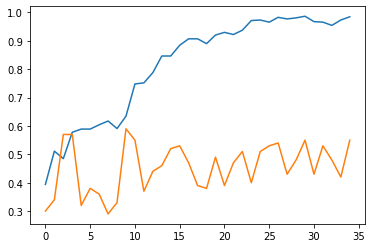

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [80]:
model.save('my_modelOutcome5')

INFO:tensorflow:Assets written to: my_modelOutcome5\assets


INFO:tensorflow:Assets written to: my_modelOutcome5\assets


In [81]:
test_predictions = model.predict(train_examples)
test_predictions = np.argmax(test_predictions, axis=-1)

In [82]:
result_df = Outcome.copy()
result_df["Predictions"] = test_predictions
result_df["Predictions"] = result_df["Predictions"].replace([0,1,2],['N','P','Q'])

result_df.to_csv(
    "predictionsOut.csv",
    columns=["Predictions","Blinding of Outcome assessment"],
    header=["Predictions","Blinding of Outcome assessment"])

In [83]:
cm = tf.math.confusion_matrix(y_val, test_predictions[:100])
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(33.0, 0.5, 'True')

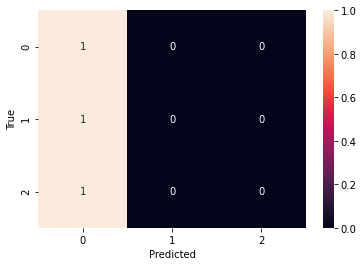

In [74]:
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")